In [16]:
from datetime import datetime

# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = [
    # Android
    'aws-amplify/amplify-android',
    'aws-amplify/aws-sdk-android',
    'awslabs/aws-mobile-appsync-sdk-android',

    # iOS
    'aws-amplify/amplify-ios',
    'aws-amplify/aws-sdk-ios',
    'awslabs/aws-mobile-appsync-sdk-ios',
    
    # JS
    'aws-amplify/amplify-js',
    
    # CLI
    'aws-amplify/amplify-cli',
    
    # Docs
    'aws-amplify/docs'
]

# Labels used across different repositories
issue_buckets = {
    'Bug': ['Bug', 'bug'],
    'Feature Request': ['Improvement', 'Feature Request', 'enhancement', 'feature-request'],
    'Question': ['Usage Question', 'Question', 'question'],
    'Pending Triage': ['Pending Triage', 'to-be-reproduced']
}

# Labels to omit from rows
omit_labels = {
    'Wont Fix', "Won't Fix", 'closing-soon-if-no-response', 'Product Review',
    'Requesting Feedback', 'Closing Soon', 'Clarification Needed', 'Duplicate',
    'Needs Info from Requester', 'work-in-progress', 'good-first-issue',
    'pending-close-response-required', 'pending-response', 'pending-release',
    'Awaiting Release', 'Investigating', 'Pending', 'Pull Request', 'duplicate',
    'good first issue', 'Reviewing', 'needs review', 'needs discussion',
    'needs-review', 'investigating', 'help wanted', 'needs-discussion',
    'Help Wanted', 'Good First Issue', 'wontfix'
}
omit_labels = omit_labels.union({label for labels in issue_buckets.values() for label in labels})

# Capture start time
start = datetime.now()

In [17]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [18]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}


def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post(
        'https://api.github.com/graphql',
        json={'query': query, 'variables': variables},
        headers=headers
    )

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [19]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']) 
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = bucket_lookup[label]
                break
                
        issues.append(
            [issue['number'], issue['title'], labels, created_at, closed_at, bucket, score]
        )
        
    repos[repo_name] = pd.DataFrame(issues, columns=[
        'id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'
    ])

In [20]:
# Utility function to generate statistics (counts, MoM, WoW, etc) for a DataFrame.

import pytz
from datetime import datetime


def generate_stats(df):
    utc = pytz.timezone('UTC')

    seven_days_ago = datetime.now() - pd.Timedelta('7 days')
    seven_days_ago = seven_days_ago.astimezone(utc)

    thirty_days_ago = datetime.now() - pd.Timedelta('30 days')
    thirty_days_ago = thirty_days_ago.astimezone(utc)

    open_issues = df[~(df.closed_at > '1970-01-01')]
    last_week_closed_issues = df[(df.closed_at > seven_days_ago)]
    last_month_closed_issues = df[(df.closed_at > thirty_days_ago)]
    last_week_open_issues = df[(df.created_at < seven_days_ago) & ~(df.closed_at < seven_days_ago)]
    last_month_open_issues = df[(df.created_at < thirty_days_ago) & ~(df.closed_at < thirty_days_ago)]
    
    open_issues_count = len(open_issues.index)
    last_week_closed_issues_count = len(last_week_closed_issues.index)
    last_month_closed_issues_count = len(last_month_closed_issues.index)
    last_week_open_issues_count = len(last_week_open_issues.index)
    last_month_open_issues_count = len(last_month_open_issues.index)
    
    return [
        open_issues_count,
        last_week_open_issues_count,
        open_issues_count - last_week_open_issues_count,
        last_month_open_issues_count,
        open_issues_count - last_month_open_issues_count,
        last_week_closed_issues_count,
        last_month_closed_issues_count
    ]

In [21]:
# Using the DataFrames, process and grab the counts of issues by repo and then by bucket.

import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.max_rows', 500)

for repo_name in repo_names:
    df = repos[repo_name]
    buckets = {bucket for bucket in df.bucket}
    
    row = [repo_name]
    row.extend(generate_stats(df))

    open_df = pd.DataFrame([row], columns=[
        'Repo', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM', 'Closed Last Week',
        'Closed Last Month'
    ])
    
    display(HTML(f'<h1>{repo_name}</h1>'))
    display(open_df)
    
    for bucket in sorted(buckets):
        bucket_counts = []
        issues = df.loc[df.bucket == bucket]
        labels = {label for labels in issues.labels for label in labels}
        row = [bucket, '']

        row.extend(generate_stats(issues))
        bucket_counts.append(row)
        
        for label in sorted(labels):
            if label in omit_labels or label in buckets:
                continue
            
            label_mask = issues.labels.apply(lambda l: label in l)
            label_issues = issues[label_mask]
            stats = generate_stats(label_issues)
            
            if sum(stats): 
                row = [bucket, label]
                row.extend(stats)
                bucket_counts.append(row)

        bucket_df = pd.DataFrame(bucket_counts, columns=[
            'Bucket', 'Label', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM',
            'Closed Last Week', 'Closed Last Month'
        ])
        
        display(HTML(f'<h2>{repo_name}: {bucket}'))
        display(bucket_df)

    display(HTML(f'<hr>'))

,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-android,30,26,4,18,12,5,9


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,16,12,4,8,8,2,4
1,Bug,API,5,4,1,5,0,1,2
2,Bug,Amplify Gradle Plugin,1,0,1,0,1,0,0
3,Bug,DataStore,9,8,1,3,6,1,2
4,Bug,Documentation,1,0,1,0,1,0,0
5,Bug,Storage,1,0,1,0,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,11,12,-1,10,1,2,2
1,Feature Request,API,3,3,0,3,0,0,0
2,Feature Request,Core,2,2,0,1,1,0,0
3,Feature Request,DataStore,3,3,0,3,0,1,1
4,Feature Request,Documentation,0,1,-1,1,-1,1,1
5,Feature Request,Infrastructure,1,1,0,1,0,0,0
6,Feature Request,Storage,1,1,0,0,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,2,1,1,0,2,1,3
1,Other,Amplify Gradle Plugin,1,0,1,0,1,0,0
2,Other,Auth,0,0,0,0,0,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,1,1,0,0,1,0,0
1,Pending Triage,Storage,1,1,0,0,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,0,0,0,0,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-android,142,140,2,125,17,1,6


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,27,27,0,27,0,0,0
1,Bug,AWSMobileClient,7,7,0,7,0,0,0
2,Bug,AppSync,1,1,0,1,0,0,0
3,Bug,Cognito,5,5,0,5,0,0,0
4,Bug,Core,2,2,0,2,0,0,0
5,Bug,IoT,2,2,0,2,0,0,0
6,Bug,KinesisVideo,2,2,0,2,0,0,0
7,Bug,Lambda,3,3,0,3,0,0,0
8,Bug,Pinpoint,3,3,0,3,0,0,0
9,Bug,S3,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,65,65,0,65,0,0,0
1,Feature Request,APIGateway,1,1,0,1,0,0,0
2,Feature Request,AWSMobileClient,15,15,0,15,0,0,0
3,Feature Request,Cognito,16,16,0,16,0,0,0
4,Feature Request,Core,5,5,0,5,0,0,0
5,Feature Request,Documentation,1,1,0,1,0,0,0
6,Feature Request,IoT,12,12,0,12,0,0,0
7,Feature Request,KinesisVideo,1,1,0,1,0,0,0
8,Feature Request,Lambda,1,1,0,1,0,0,0
9,Feature Request,Other AWS Services,2,2,0,2,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,25,22,3,8,17,0,4
1,Other,AWSMobileClient,10,8,2,3,7,0,0
2,Other,Cognito,5,5,0,1,4,0,0
3,Other,DynamoDB,1,1,0,1,0,0,0
4,Other,IoT,1,1,0,2,-1,0,1
5,Other,Sample App,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,2,2,0,1,1,0,0
1,Pending Triage,S3,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,23,24,-1,24,-1,1,2
1,Question,APIGateway,3,3,0,3,0,0,0
2,Question,AWSMobileClient,8,8,0,9,-1,0,1
3,Question,Cognito,4,5,-1,4,0,1,1
4,Question,Core,2,2,0,2,0,0,0
5,Question,Documentation,1,1,0,1,0,0,0
6,Question,IoT,2,2,0,2,0,0,0
7,Question,KinesisVideo,1,1,0,1,0,0,0
8,Question,Pinpoint,2,2,0,2,0,0,0
9,Question,S3,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-android,47,48,-1,47,0,1,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,17,17,0,17,0,0,0
1,Bug,AppSync,16,16,0,16,0,0,0
2,Bug,Codegen,2,2,0,2,0,0,0
3,Bug,Documentation,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,13,13,0,13,0,0,0
1,Feature Request,AppSync,12,12,0,12,0,0,0
2,Feature Request,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,8,9,-1,8,0,1,2
1,Other,AppSync,2,3,-1,3,-1,1,1
2,Other,Codegen,1,1,0,1,0,0,0
3,Other,Infrastructure,0,1,-1,1,-1,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,9,9,0,9,0,0,0
1,Question,AppSync,9,9,0,9,0,0,0
2,Question,Documentation,1,1,0,1,0,0,0
3,Question,Infrastructure,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-ios,71,70,1,62,9,13,20


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,16,15,1,15,1,5,6
1,Bug,API,2,2,0,2,0,0,0
2,Bug,Analytics,0,1,-1,1,-1,1,1
3,Bug,Auth,1,0,1,0,1,0,0
4,Bug,Build,4,0,4,0,4,1,1
5,Bug,Codable Enums,1,1,0,1,0,0,0
6,Bug,Core,1,1,0,1,0,0,0
7,Bug,DataStore,7,9,-2,9,-2,3,4
8,Bug,P0,1,1,0,1,0,0,0
9,Bug,Storage,2,2,0,2,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,18,18,0,17,1,0,0
1,Feature Request,Core,5,5,0,4,1,0,0
2,Feature Request,DataStore,11,11,0,11,0,0,0
3,Feature Request,P0,4,4,0,4,0,0,0
4,Feature Request,Storage,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,33,33,0,27,6,7,13
1,Other,API,7,7,0,7,0,0,0
2,Other,Analytics,2,2,0,0,2,0,0
3,Other,Auth,1,2,-1,0,1,1,4
4,Other,Build,3,3,0,3,0,0,0
5,Other,Codable Enums,1,1,0,1,0,0,0
6,Other,Core,2,2,0,2,0,0,0
7,Other,DataStore,20,17,3,17,3,1,1
8,Other,P0,2,2,0,2,0,0,0
9,Other,P1,1,1,0,1,0,0,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,4,4,0,3,1,1,1
1,Question,API,1,1,0,0,1,0,0
2,Question,DataStore,2,2,0,2,0,1,1
3,Question,amplify-app,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-ios,204,201,3,182,22,4,13


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,41,41,0,37,4,1,3
1,Bug,APIGateway,1,1,0,1,0,0,0
2,Bug,AWSMobileClient,8,9,-1,7,1,1,1
3,Bug,AppSync,2,2,0,2,0,0,0
4,Bug,Cognito,4,4,0,5,-1,0,1
5,Bug,Core,1,1,0,1,0,0,0
6,Bug,Documentation,1,1,0,1,0,0,0
7,Bug,IoT,10,10,0,11,-1,0,1
8,Bug,Pinpoint,7,6,1,2,5,0,0
9,Bug,S3,10,10,0,10,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,86,86,0,82,4,0,0
1,Feature Request,APIGateway,4,4,0,4,0,0,0
2,Feature Request,AWSMobileClient,23,23,0,21,2,0,0
3,Feature Request,Build,2,2,0,2,0,0,0
4,Feature Request,Cognito,21,21,0,19,2,0,0
5,Feature Request,Core,1,1,0,1,0,0,0
6,Feature Request,Documentation,1,1,0,1,0,0,0
7,Feature Request,DynamoDB,1,1,0,1,0,0,0
8,Feature Request,Infrastructure,2,2,0,2,0,0,0
9,Feature Request,IoT,8,8,0,8,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,41,37,4,34,7,1,7
1,Other,APIGateway,1,1,0,2,-1,0,1
2,Other,AWSMobileClient,6,6,0,9,-3,0,4
3,Other,Cognito,14,14,0,11,3,0,0
4,Other,Core,1,1,0,1,0,0,0
5,Other,Documentation,0,0,0,1,-1,0,1
6,Other,FrameworkBuild,1,1,0,1,0,0,0
7,Other,Infrastructure,1,1,0,0,1,0,0
8,Other,IoT,3,3,0,3,0,0,0
9,Other,S3,11,11,0,10,1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,36,37,-1,29,7,2,3
1,Question,APIGateway,2,2,0,2,0,0,0
2,Question,AWSMobileClient,2,3,-1,2,0,1,1
3,Question,AppSync,2,3,-1,1,1,1,1
4,Question,Cognito,10,10,0,8,2,0,0
5,Question,Core,1,1,0,1,0,0,0
6,Question,Documentation,1,1,0,1,0,0,0
7,Question,EC2,1,1,0,1,0,0,0
8,Question,FrameworkBuild,1,1,0,1,0,0,0
9,Question,IoT,3,3,0,3,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-ios,66,66,0,64,2,1,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,20,20,0,21,-1,0,1
1,Bug,AppSync,19,19,0,20,-1,0,1
2,Bug,Documentation,1,1,0,1,0,0,0
3,Bug,Service,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,21,21,0,21,0,0,0
1,Feature Request,AppSync,19,19,0,19,0,0,0
2,Feature Request,Build,1,1,0,1,0,0,0
3,Feature Request,Documentation,3,3,0,3,0,0,0
4,Feature Request,Infrastructure,1,1,0,1,0,0,0
5,Feature Request,tvOS,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,9,9,0,8,1,1,1
1,Other,AppSync,7,7,0,7,0,0,0
2,Other,Build,1,1,0,1,0,0,0
3,Other,Tests,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,16,16,0,14,2,0,0
1,Question,AppSync,12,12,0,12,0,0,0
2,Question,Build,2,2,0,1,1,0,0
3,Question,Documentation,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-js,588,598,-10,596,-8,52,159


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,39,51,-12,57,-18,12,28
1,Bug,API,2,2,0,1,1,0,0
2,Bug,Amplify UI Components,2,2,0,1,1,0,0
3,Bug,Analytics,1,1,0,1,0,0,0
4,Bug,Angular,3,4,-1,6,-3,1,3
5,Bug,Auth,10,15,-5,21,-11,5,12
6,Bug,Browser Compatibly,1,1,0,1,0,0,0
7,Bug,Cognito,8,8,0,8,0,0,0
8,Bug,DataStore,4,5,-1,4,0,1,2
9,Bug,Federation,1,1,0,0,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,328,335,-7,331,-3,9,28
1,Feature Request,API,13,13,0,14,-1,0,1
2,Feature Request,Amplify UI Components,15,16,-1,10,5,1,2
3,Feature Request,Analytics,10,10,0,10,0,0,0
4,Feature Request,Angular,14,14,0,15,-1,0,1
5,Feature Request,AppSync,6,6,0,6,0,0,0
6,Feature Request,Auth,73,73,0,72,1,0,1
7,Feature Request,Build,3,3,0,3,0,0,0
8,Feature Request,Caching,1,1,0,1,0,0,0
9,Feature Request,Cognito,51,51,0,52,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,76,79,-3,91,-15,16,55
1,Other,API,8,6,2,5,3,0,0
2,Other,Amplify UI Components,1,1,0,3,-2,3,9
3,Other,Analytics,3,3,0,5,-2,0,2
4,Other,Angular,4,4,0,7,-3,2,6
5,Other,AppSync,5,4,1,4,1,0,2
6,Other,Auth,33,32,1,33,0,3,11
7,Other,Browser Compatibly,1,1,0,1,0,0,0
8,Other,Build,0,0,0,1,-1,0,1
9,Other,Can't reproduce,3,3,0,3,0,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,86,75,11,57,29,10,36
1,Pending Triage,API,5,5,0,3,2,0,0
2,Pending Triage,Amplify UI Components,1,1,0,1,0,0,0
3,Pending Triage,Analytics,2,2,0,1,1,0,1
4,Pending Triage,Angular,5,5,0,4,1,0,0
5,Pending Triage,AppSync,4,4,0,4,0,0,0
6,Pending Triage,Auth,24,22,2,20,4,0,5
7,Pending Triage,Cognito,3,2,1,2,1,0,0
8,Pending Triage,DataStore,11,9,2,9,2,3,11
9,Pending Triage,Federation,2,2,0,2,0,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,59,58,1,60,-1,5,12
1,Question,API,2,2,0,2,0,2,2
2,Question,Analytics,1,1,0,1,0,0,0
3,Question,Angular,3,3,0,3,0,0,0
4,Question,AppSync,6,6,0,6,0,0,0
5,Question,Auth,23,25,-2,23,0,3,5
6,Question,Cognito,6,5,1,5,1,0,0
7,Question,DataStore,6,4,2,4,2,0,0
8,Question,GraphQL,4,4,0,5,-1,0,1
9,Question,Hub,0,0,0,1,-1,0,1


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-cli,595,577,18,590,5,28,186


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,61,56,5,59,2,2,25
1,Bug,@auth,3,3,0,2,1,0,0
2,Bug,@key,1,2,-1,3,-2,1,2
3,Bug,DataStore,1,1,0,1,0,0,1
4,Bug,amplify-app,1,1,0,1,0,0,1
5,Bug,analytics,1,0,1,0,1,0,0
6,Bug,aurora,1,0,1,0,1,0,0
7,Bug,auth,3,3,0,3,0,0,0
8,Bug,cloudformation,1,1,0,1,0,0,0
9,Bug,code-gen,7,7,0,5,2,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,438,437,1,412,26,6,25
1,Feature Request,@auth,6,6,0,5,1,0,0
2,Feature Request,@connection,1,1,0,2,-1,0,1
3,Feature Request,@key,4,4,0,4,0,0,0
4,Feature Request,@searchable,4,3,1,0,4,0,0
5,Feature Request,DataStore,7,7,0,9,-2,0,2
6,Feature Request,REST API,13,13,0,11,2,0,0
7,Feature Request,RFC,3,3,0,3,0,0,0
8,Feature Request,analytics,2,2,0,2,0,0,0
9,Feature Request,aurora,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,66,53,13,80,-14,14,85
1,Other,@auth,2,2,0,1,1,0,2
2,Other,@key,0,1,-1,0,0,1,1
3,Other,@searchable,1,0,1,2,-1,0,2
4,Other,DataStore,3,4,-1,5,-2,1,4
5,Other,REST API,0,0,0,2,-2,0,2
6,Other,RFC,5,5,0,6,-1,0,1
7,Other,amplify-app,1,0,1,0,1,0,0
8,Other,amplify-console,0,1,-1,1,-1,1,2
9,Other,analytics,0,1,-1,1,-1,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,30,31,-1,39,-9,6,51
1,Question,@auth,3,3,0,3,0,0,2
2,Question,@connection,0,0,0,0,0,0,1
3,Question,@key,1,1,0,1,0,0,0
4,Question,@searchable,0,0,0,0,0,0,1
5,Question,DataStore,3,3,0,4,-1,0,1
6,Question,REST API,0,0,0,1,-1,0,1
7,Question,aurora,0,0,0,0,0,0,1
8,Question,auth,4,3,1,2,2,1,4
9,Question,cloudformation,1,2,-1,1,0,1,1


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/docs,96,91,5,93,3,8,45


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,0,0,0,1,-1,1,3
1,Bug,Android Lib,0,0,0,0,0,0,1
2,Bug,CLI,0,0,0,1,-1,0,1
3,Bug,feedback requested,0,0,0,0,0,1,1
4,Bug,iOS Lib,0,0,0,0,0,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,9,9,0,8,1,0,0
1,Feature Request,CLI,2,2,0,2,0,0,0
2,Feature Request,JavaScript,2,2,0,2,0,0,0
3,Feature Request,documentation site,3,3,0,2,1,0,0
4,Feature Request,iOS SDK,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,86,82,4,84,2,6,41
1,Other,Android Lib,2,2,0,2,0,0,0
2,Other,Android SDK,2,2,0,2,0,0,1
3,Other,CLI,27,27,0,30,-3,2,11
4,Other,Getting Started,1,1,0,0,1,0,0
5,Other,JavaScript,30,28,2,33,-3,1,15
6,Other,UI,13,13,0,7,6,0,0
7,Other,documentation site,7,9,-2,9,-2,2,4
8,Other,feedback requested,1,0,1,0,1,0,0
9,Other,iOS Lib,3,3,0,2,1,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,0,0,0,0,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,1,0,1,0,1,1,1
1,Question,CLI,1,0,1,0,1,1,1


In [22]:
# Top Open Bugs by Activity

from IPython.core.display import HTML

display(HTML(f'<h1>Top Open Bugs by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Bug']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(5))

# Top Open Feature Requests by Activity

display(HTML(f'<h1>Top Open Feature Requests by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Feature Request']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)
    
    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(5))

,id,title,created_at,labels,score
29,216,GsonVariablesSerializer should support ISO 860...,2020-01-02 22:13:34+00:00,"[API, Bug]",4
70,458,SQLiteException: no such table,2020-05-13 21:30:54+00:00,"[Bug, DataStore]",4
18,186,[API] Subscribe fails if model has owner autho...,2019-12-10 16:49:38+00:00,"[API, Bug]",2
31,220,[StorageEngine] Support storing lists and quer...,2020-01-06 23:21:05+00:00,"[Bug, DataStore]",2
32,221,[API] Gson serializer does not handle timezone...,2020-01-07 01:18:29+00:00,"[API, Bug]",2


,id,title,created_at,labels,score
801,1259,AWSIotMqttManager NoClassDefFoundError with An...,2019-10-16 19:36:15+00:00,"[Bug, IoT]",29
895,1507,Logged out after changing permission,2020-03-06 09:29:30+00:00,"[Bug, Core, Pending Triage]",15
680,956,Sign in issue in AmazonKinesisVideoDemoApp,2019-05-13 21:40:47+00:00,"[AWSMobileClient, Bug]",5
923,1656,Can't login with Facebook on Android if accoun...,2020-04-28 13:00:56+00:00,"[Bug, Cognito, Needs Info from Requester]",4
803,1264,NullPointerException Attempt to invoke virtual...,2019-10-21 12:43:01+00:00,"[AWSMobileClient, Bug]",3


,id,title,created_at,labels,score
146,246,"Subscription initialization throws ""Invalid me...",2020-01-15 15:23:59+00:00,"[AppSync, Bug]",10
122,206,Disabling cache not working in Appsync / appollo,2019-07-18 21:06:12+00:00,"[AppSync, Bug]",7
150,257,Subscriptions don't work in 3.0.x; NullPointer...,2020-02-04 08:58:26+00:00,"[AppSync, Bug]",4
123,207,Delta sync base query always runs again after ...,2019-07-23 06:08:10+00:00,"[AppSync, Bug]",4
92,145,[Performance] Apollo NormalizedCache performs ...,2019-04-08 10:57:32+00:00,"[AppSync, Bug]",3


,id,title,created_at,labels,score
60,246,Codegen failure: Enum types generates an inval...,2019-12-10 07:37:41+00:00,"[Bug, Codable Enums, DataStore]",5
139,480,1.0.0-rc.1 crashes at runtime when APIPlugin i...,2020-05-22 19:21:44+00:00,"[Bug, DataStore]",5
56,241,doc : datastore init sample code fails,2019-12-09 17:52:14+00:00,"[Bug, DataStore, documentation]",4
80,285,Storage plugin saves error message at intended...,2020-01-05 18:42:37+00:00,"[Bug, Storage]",4
35,127,Remove unknown and notInProcess async event cases,2019-11-20 18:01:50+00:00,"[Bug, Core, P0]",2


,id,title,created_at,labels,score
1031,1217,Crash in AWSAuthCore *** -[__NSPlaceholderDict...,2019-02-07 07:29:10+00:00,"[AWSMobileClient, bug]",8
761,861,Unable to successfully update endpoint.,2018-03-29 07:18:29+00:00,"[Pinpoint, Requesting Feedback, bug]",6
1069,1262,non-ascii characters in user claims sometimes ...,2019-03-05 00:55:02+00:00,"[AWSMobileClient, Cognito, bug]",6
1509,2598,awscognitoauthclienterror check always fails,2020-05-16 16:12:07+00:00,"[AWSMobileClient, bug]",5
1080,1278,Crash in AWSMobileClient.getTokens(),2019-03-11 21:52:03+00:00,"[AWSMobileClient, bug]",5


,id,title,created_at,labels,score
48,92,Optimistic update fails if cache is empty,2018-10-31 01:18:42+00:00,"[AppSync, Bug]",14
207,383,Pending S3 Uploads after app restart,2020-04-13 14:37:39+00:00,[Bug],6
90,180,Setting property to nil via generated Swift ap...,2019-02-13 18:25:22+00:00,"[AppSync, Bug]",3
160,290,Sending offline mutations after access token e...,2019-08-15 21:20:05+00:00,"[AppSync, Bug]",3
96,189,Mutation is lost when network connection is bad,2019-02-27 19:09:18+00:00,"[AppSync, Bug, Investigating]",2


,id,title,created_at,labels,score
2937,4681,"After upgrade to Angular 9 get error ""ERROR in...",2020-01-08 09:14:17+00:00,"[Angular, bug]",143
2591,4089,support RN-0.60.+ for @aws-amplify/pushnotific...,2019-09-26 16:34:03+00:00,"[Push Notifications, React Native, bug]",44
2675,4257,GraphQLResult and Observable<object> incorrect...,2019-10-25 04:09:48+00:00,"[GraphQL, bug]",20
2672,4244,React-native Auth.federatedSignIn() redirectio...,2019-10-24 12:53:29+00:00,"[Auth, React Native, bug]",13
2186,3431,Delete linked user from User pool users.,2019-06-11 18:24:57+00:00,"[Cognito, Service Team, bug]",11


,id,title,created_at,labels,score
399,682,Error: Only one resolver is allowed per field,2019-01-09 09:04:54+00:00,"[bug, dependency-issue, graphql-transformer]",83
1219,1874,Get apiaivyGraphQLAPIIdOutput in auto generate...,2019-07-20 16:26:02+00:00,"[bug, functions]",51
2085,3284,Peer dependency missing,2020-01-27 20:24:32+00:00,"[bug, interactions]",13
1421,2199,AWSDateTime scalar is not currently supported ...,2019-09-03 13:53:57+00:00,"[bug, dependency-issue, graphql-transformer]",11
1747,2715,subscribing to models requires update operation,2019-11-11 15:39:17+00:00,"[bug, graphql-transformer, pending-release]",11


,id,title,created_at,labels,score


,id,title,created_at,labels,score
17,185,[API] Subscribe fails for API auth types other...,2019-12-10 16:46:48+00:00,"[API, Improvement]",3
50,303,Using Custom GraphQL Endpoint,2020-03-13 08:49:34+00:00,"[API, Feature Request]",3
57,360,Expose callback to know when mutation queue is...,2020-04-07 16:05:22+00:00,"[DataStore, Feature Request]",3
23,210,[API] GraphQL - Support for different Id field...,2020-01-02 17:12:42+00:00,"[API, Feature Request]",2
28,215,Amplify Initialization and Teardown,2020-01-02 22:04:09+00:00,"[Core, Feature Request]",2


,id,title,created_at,labels,score
572,684,Custom scopes in access token programmatically,2019-02-02 19:28:41+00:00,"[Cognito, Feature Request]",140
412,471,AWS Auth compatibility for API 22 and lower,2018-05-29 23:06:45+00:00,"[Cognito, Feature Request]",33
858,1436,TransferUtility upload - Support InputStream a...,2020-01-17 00:06:38+00:00,"[Feature Request, S3]",24
442,505,Upload multiple files using TransferUtility,2018-08-04 17:50:33+00:00,"[Feature Request, S3]",22
476,547,Add Secrets Manager to Android and iOS SDKs,2018-10-16 19:30:45+00:00,"[Core, Feature Request]",10


,id,title,created_at,labels,score
41,74,RXJava support,2018-12-03 07:30:45+00:00,"[AppSync, Feature Request]",9
99,155,Use Android apollo-client as a dependency inst...,2019-04-23 10:19:40+00:00,"[AppSync, Feature Request]",6
68,113,Including Mutation Payload in PersistentMutati...,2019-02-05 14:15:58+00:00,"[AppSync, Feature Request]",4
38,70,How can I know the time when a subscription ha...,2018-11-28 10:53:46+00:00,"[AppSync, Feature Request]",2
44,77,Mapping AWS built-in scalar types,2018-12-05 00:54:39+00:00,"[AppSync, Feature Request]",2


,id,title,created_at,labels,score
122,403,Using `@auth` directive with `{ allow: owner }...,2020-04-23 22:15:04+00:00,[enhancement],8
82,288,Feature request: clear/flush DataStore,2020-01-09 16:45:06+00:00,"[DataStore, enhancement]",5
135,460,Support custom file name of amplifyconfigurati...,2020-05-19 10:54:31+00:00,"[Core, enhancement]",4
76,277,@connection seems to be partially supported......,2019-12-24 03:06:36+00:00,"[DataStore, enhancement]",3
41,161,Make Logging and Hub categories available at i...,2019-11-26 00:08:17+00:00,"[Core, P0, enhancement]",2


,id,title,created_at,labels,score
279,313,Support Swift Package Manager,2016-02-04 15:40:27+00:00,"[Build, Infrastructure, feature-request]",75
860,993,Facebook/Google signup to User Pool,2018-07-14 00:29:29+00:00,"[Cognito, Service, feature-request]",73
1202,1603,Cannot compile for UIKit for Mac,2019-06-09 21:56:49+00:00,"[MacOS-SDK, feature-request]",36
720,815,AWS AuthUI without Navigation Controller,2018-01-19 08:56:58+00:00,"[Cognito, feature-request]",9
1036,1222,Customize Drop-in auth UI to just require emai...,2019-02-07 21:59:21+00:00,"[AWSMobileClient, feature-request]",9


,id,title,created_at,labels,score
76,157,Improve documentation on using AWSMobileClient...,2019-01-17 17:10:19+00:00,"[AppSync, Documentation, Feature Request]",33
6,8,how can I send a push notification (apns) when...,2018-03-13 16:34:03+00:00,"[AppSync, Documentation, Feature Request]",20
4,6,Feature Request: uploading multiple S3 object ...,2018-03-12 16:41:44+00:00,"[AppSync, Feature Request]",12
158,288,Add support for Swift Package Manager,2019-08-11 12:54:14+00:00,"[Build, Feature Request, Infrastructure]",9
69,143,Make AWSAppSyncOfflineMutationDelegate useful,2019-01-03 10:07:51+00:00,"[AppSync, Feature Request]",7


,id,title,created_at,labels,score
1145,1852,Flutter support,2018-10-06 02:26:17+00:00,[feature-request],2128
2188,3435,cognito.user.signOut() does not invalidate tokens,2019-06-12 09:36:41+00:00,"[Cognito, Service Team, feature-request]",250
1003,1613,"AppSync, AWS Amplify and SSR",2018-09-11 15:30:13+00:00,"[AppSync, SSR, feature-request]",231
1610,2562,Auto signin after confirm email,2019-01-17 13:45:42+00:00,"[Auth, feature-request]",145
185,329,Support for multiple buckets?,2018-02-21 18:49:36+00:00,"[Storage, feature-request]",83


,id,title,created_at,labels,score
639,1043,RFC - @auth directive improvements,2019-03-14 22:16:14+00:00,"[RFC, enhancement, graphql-transformer]",232
456,779,Use existing Cognito User pool with amplify auth,2019-01-28 09:31:52+00:00,"[auth, feature-request]",220
410,703,Add support for deploying/managing lambda layers,2019-01-14 03:53:30+00:00,"[feature-request, functions]",139
888,1406,Enhance Amplify Push Workflow,2019-05-07 08:05:03+00:00,"[enhancement, graphql-transformer, platform]",137
1214,1865,Total counts in GraphQL queries,2019-07-19 01:58:59+00:00,"[feature-request, graphql-transformer, pending...",79


,id,title,created_at,labels,score
187,766,"Documentation about the ""aws-exports"" file",2019-02-07 14:45:17+00:00,"[CLI, feature-request]",81
406,1661,RFC: Learn section on the docs,2020-04-28 23:00:32+00:00,[feature-request],29
177,735,Document awsconfiguration.json format and usage,2019-06-13 16:55:50+00:00,"[CLI, feature-request]",13
37,281,Rehydrated reason for use,2018-12-05 23:17:00+00:00,"[JavaScript, feature-request]",6
184,755,Add Documentation for Other Auth Providers,2019-06-26 11:48:04+00:00,"[JavaScript, feature-request]",6


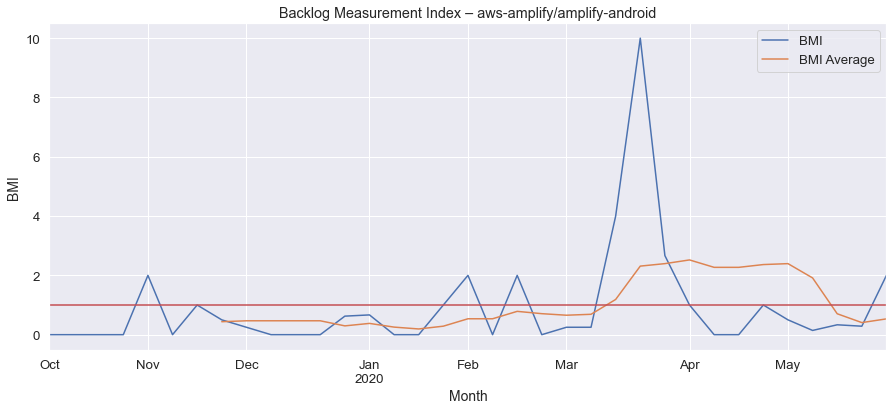

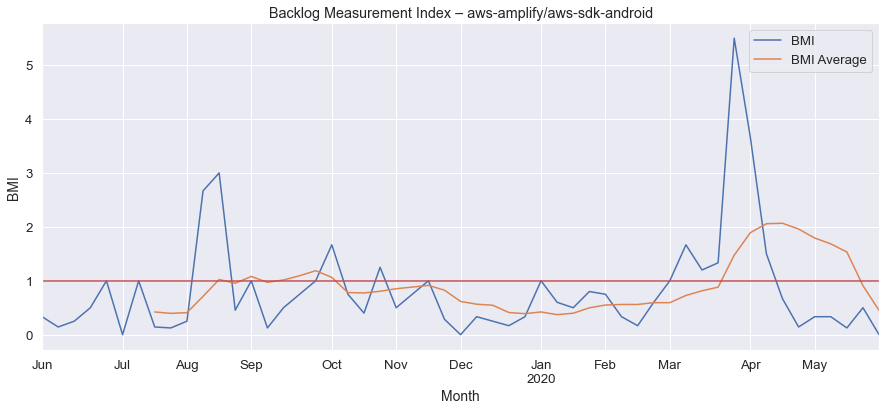

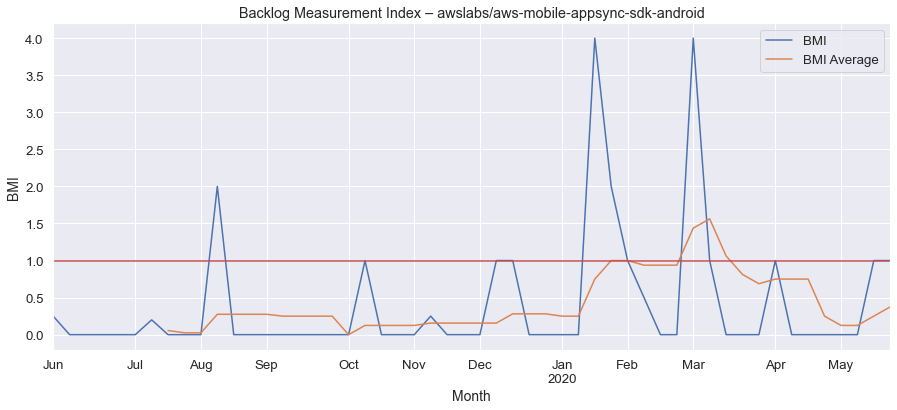

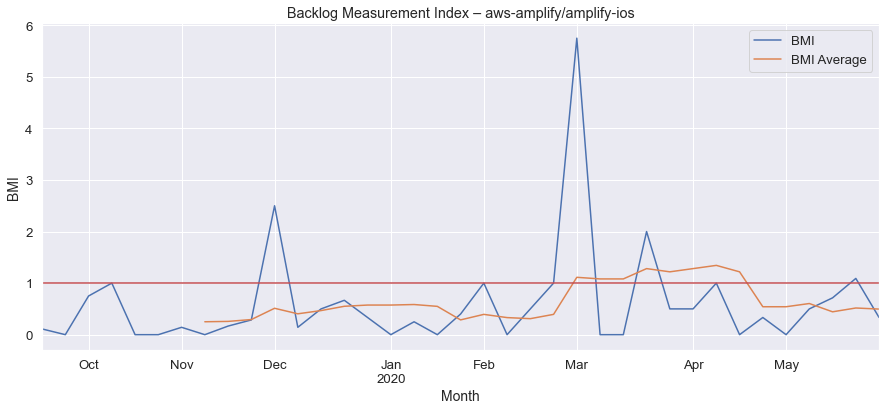

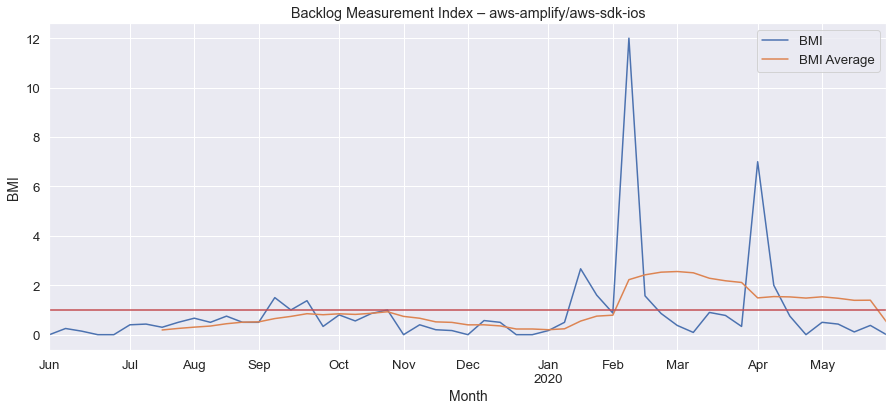

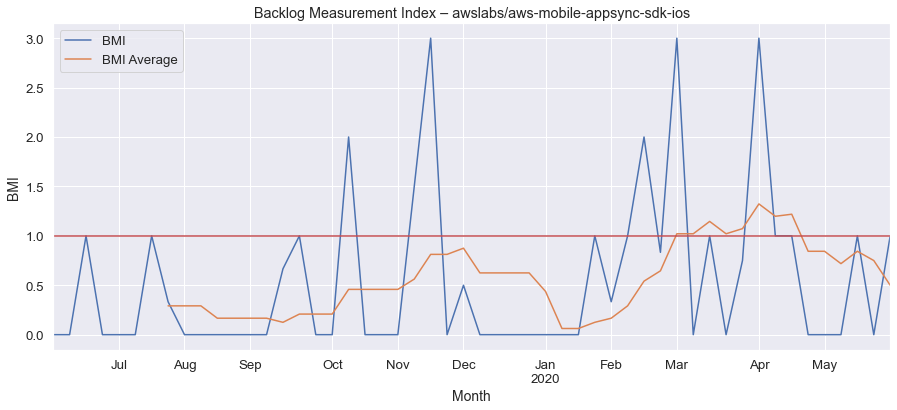

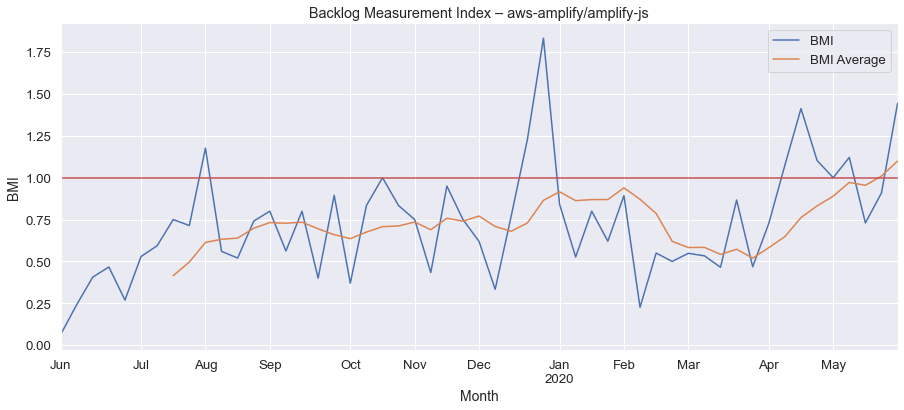

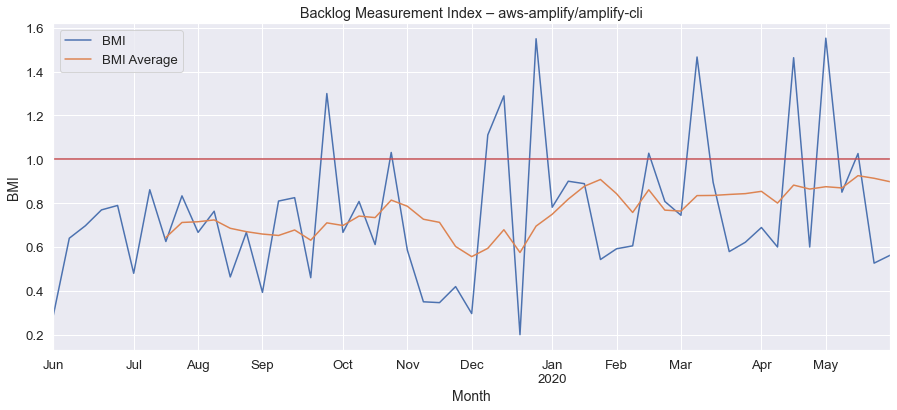

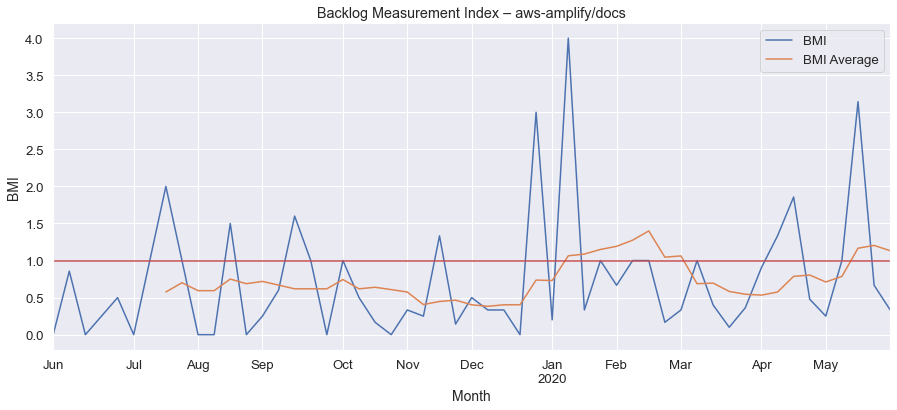

In [23]:
# Backlog Management Index

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items(): 
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 

    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

    both['Closed'] = both['Closed'].fillna(0)
    both['Opened'] = both['Opened'].fillna(0)
    both['BMI'] = both['Closed'] / both['Opened']
    both['BMI'] = both['BMI'].replace([np.inf, -np.inf], np.nan)
    both['BMI'] = both['BMI'].fillna(both['Closed'])

    both['BMI Average'] = both['BMI'].rolling(window=8).mean()

    ax = both[['BMI', 'BMI Average']].plot(kind='line', figsize=(15, 6), legend=True)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('BMI', fontsize=14)
    
    ax.set(title=f'Backlog Measurement Index – {repo_name}')
    
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.show()

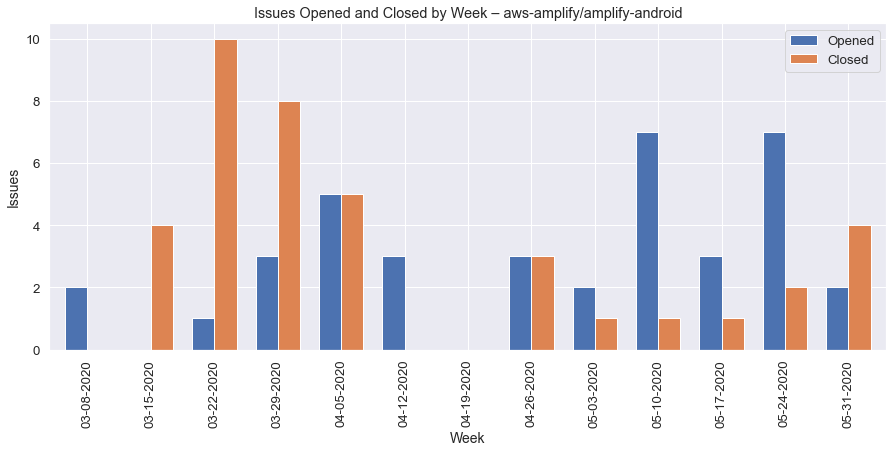

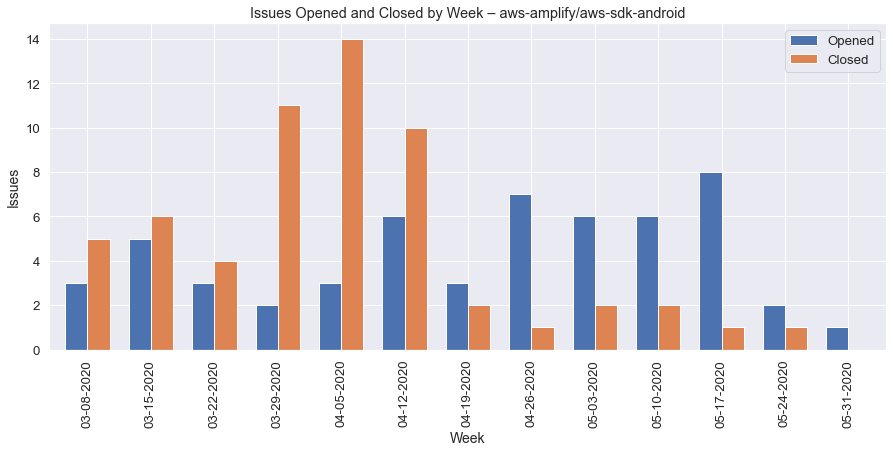

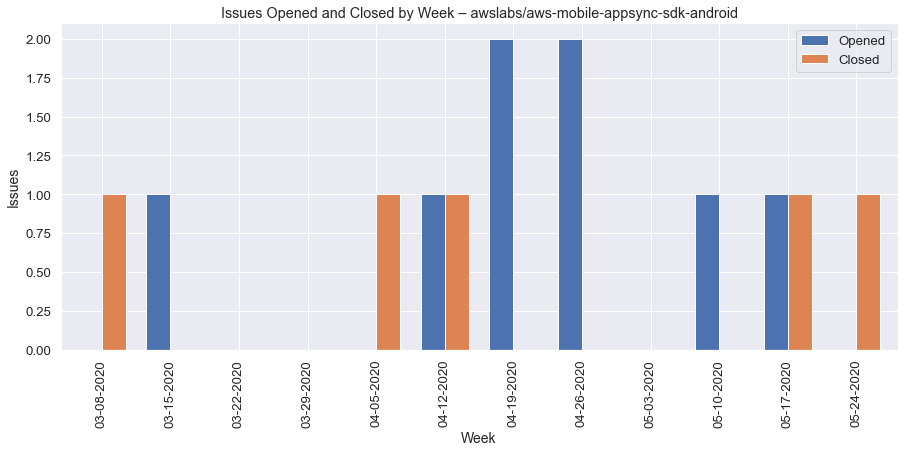

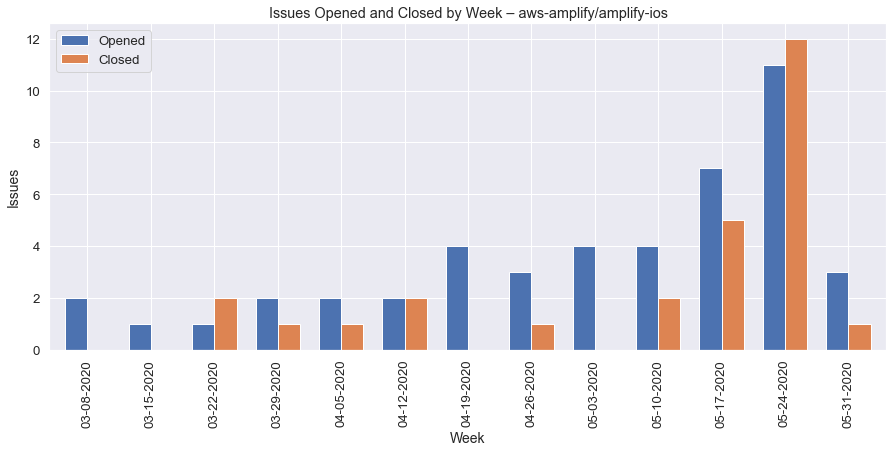

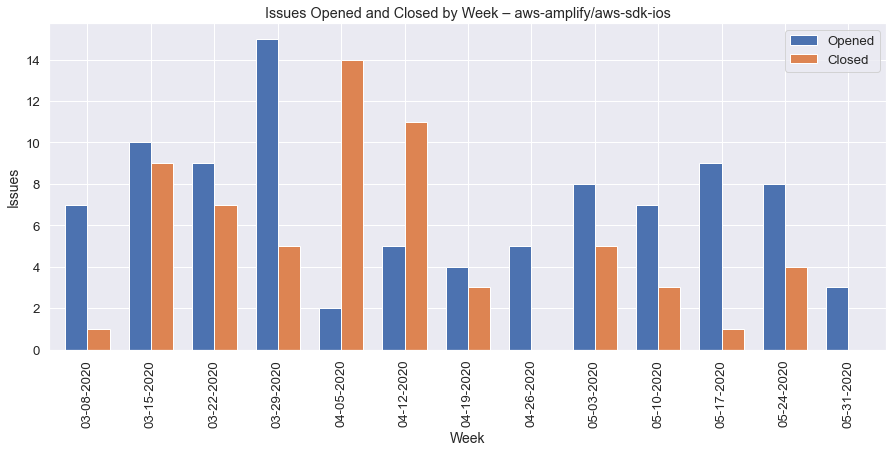

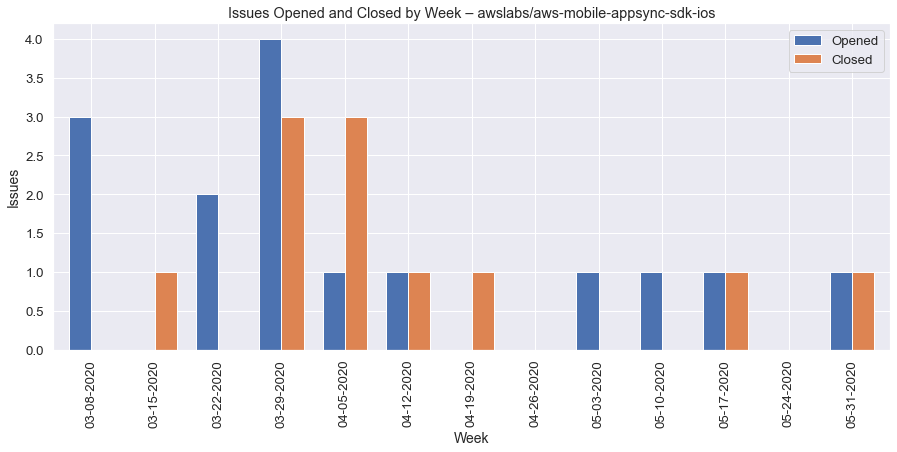

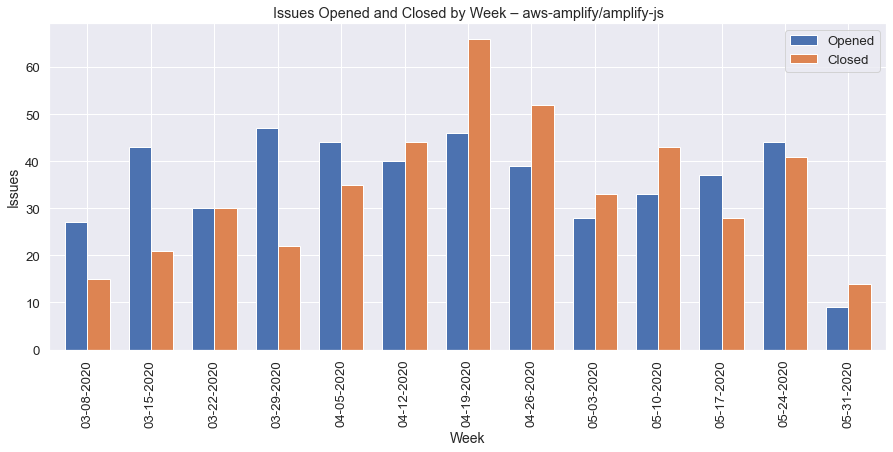

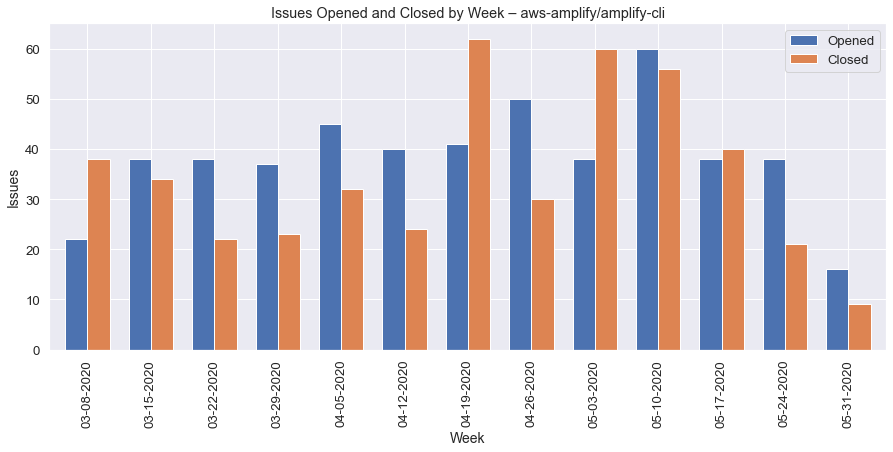

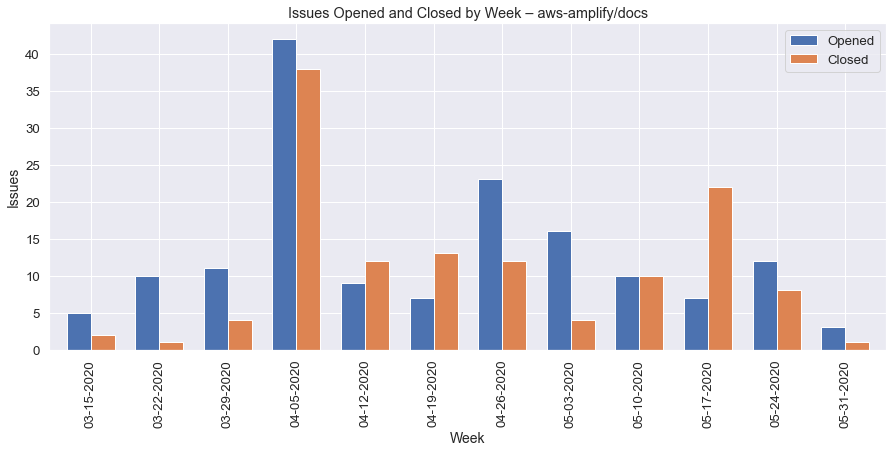

In [24]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > now - timedelta(weeks=12))] 
    closed = df.loc[(df.closed_at > now - timedelta(weeks=12))] 
    
    opened = opened.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = closed.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 6), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()

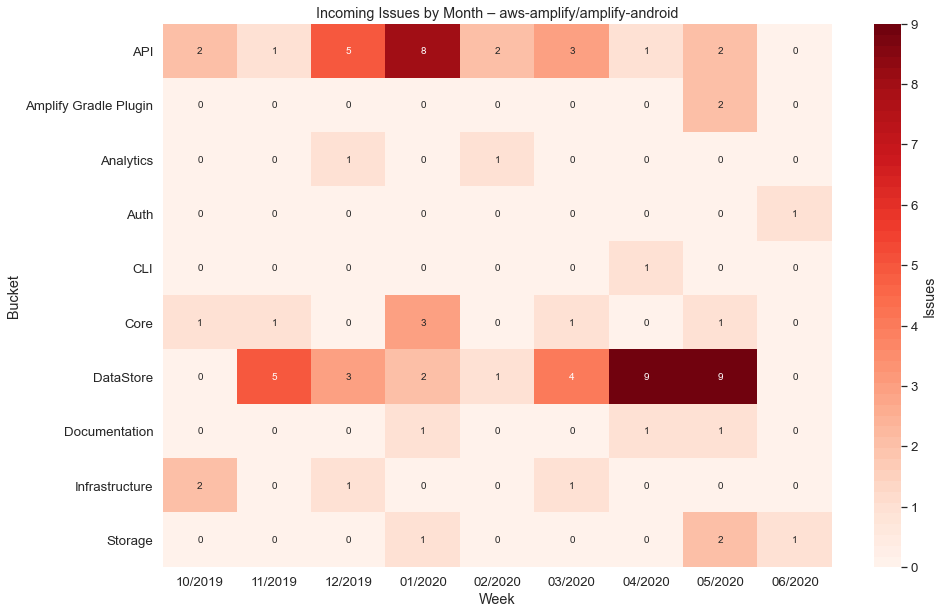

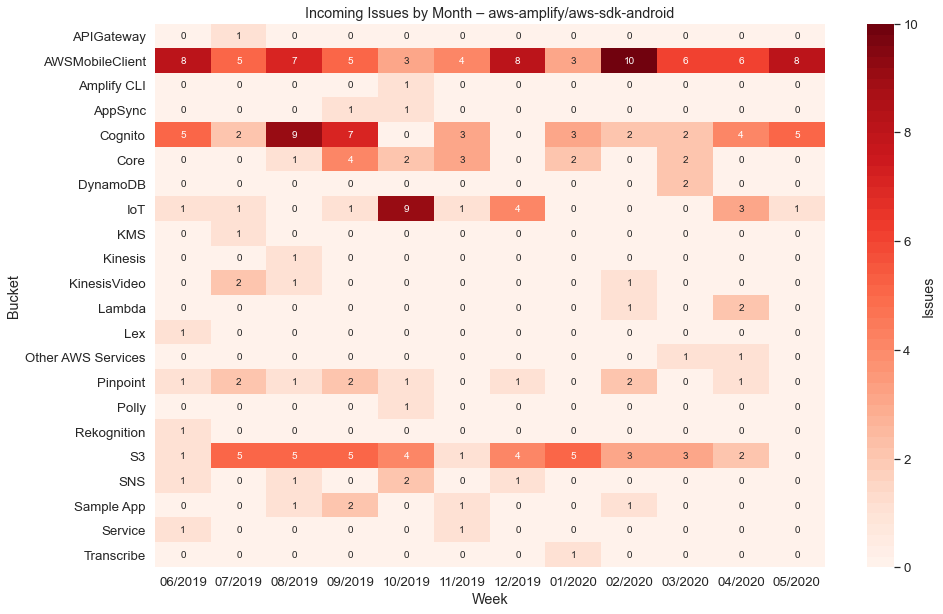

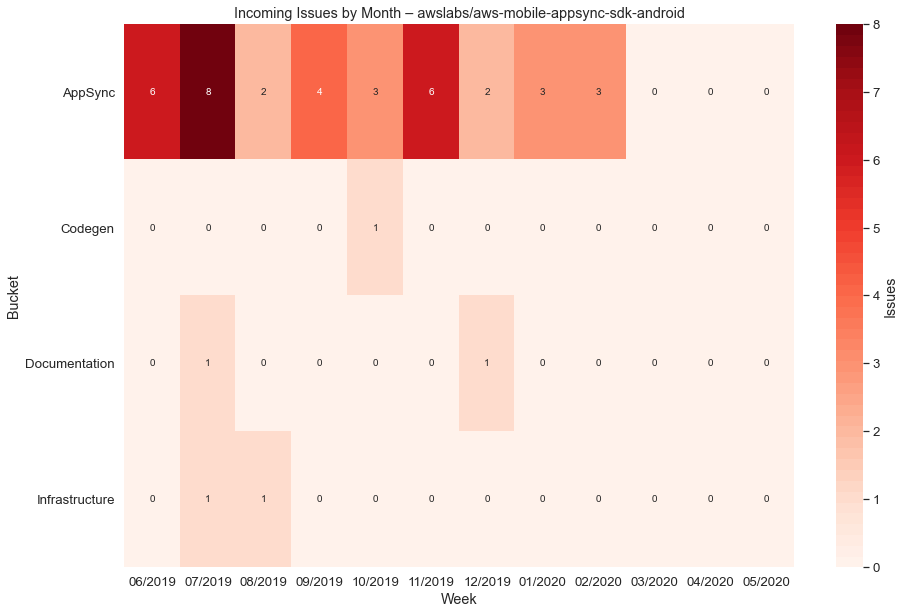

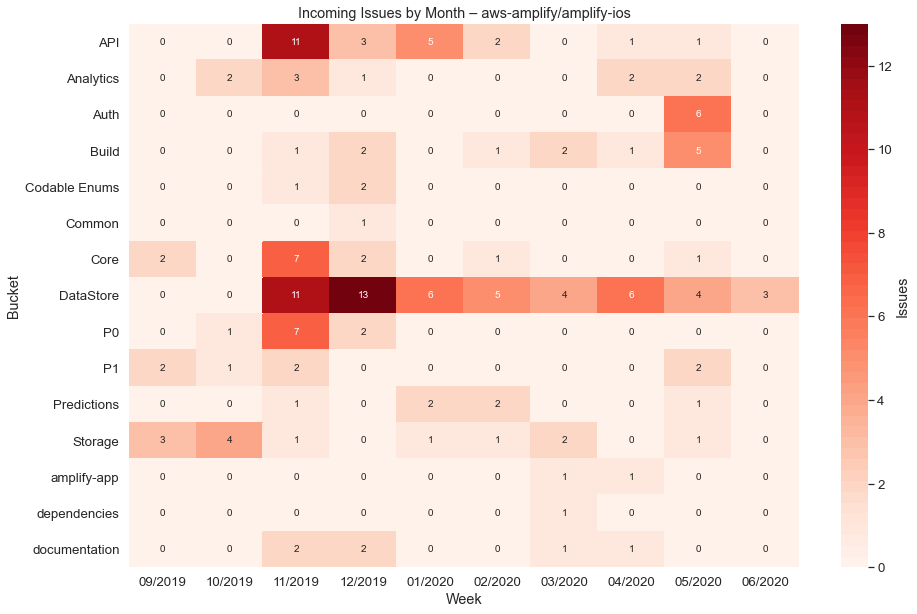

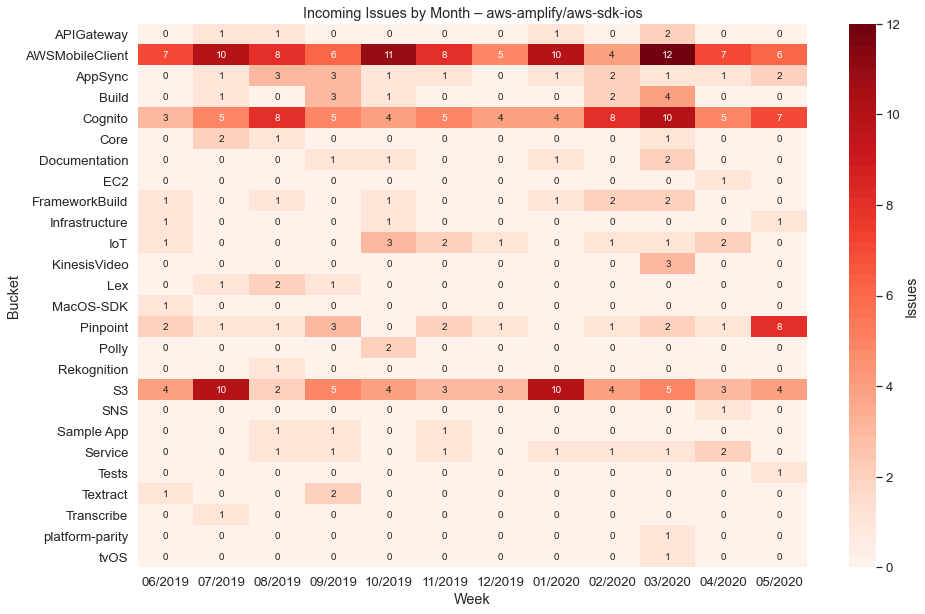

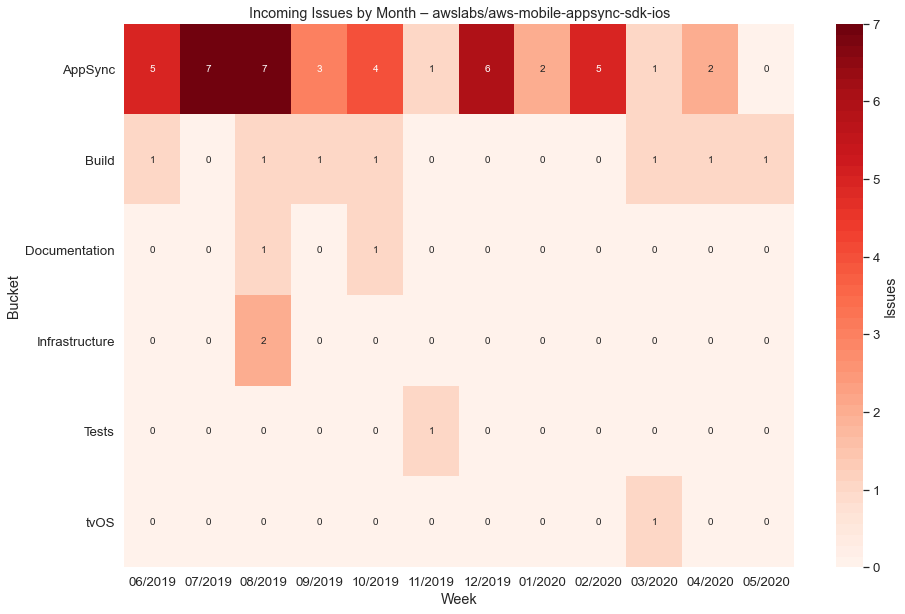

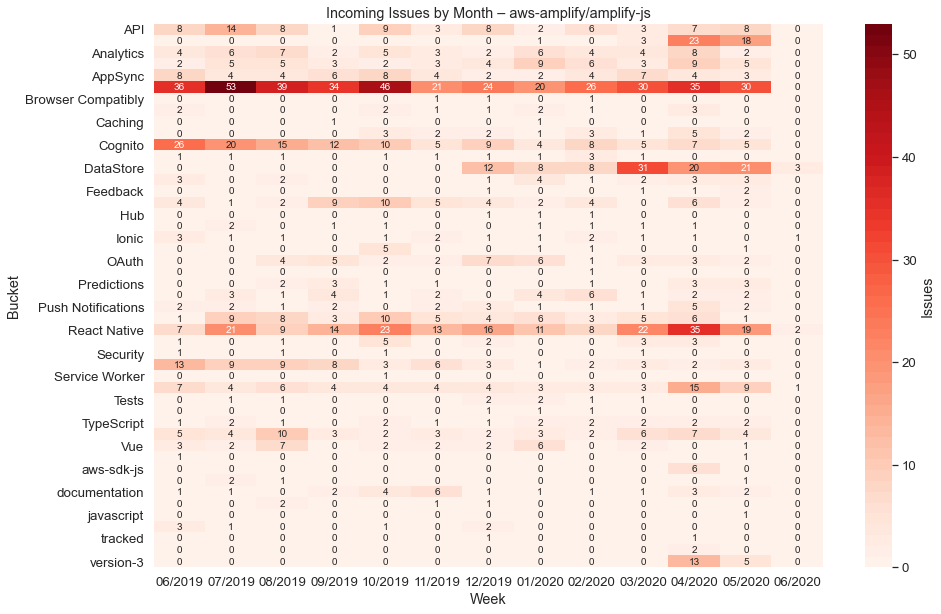

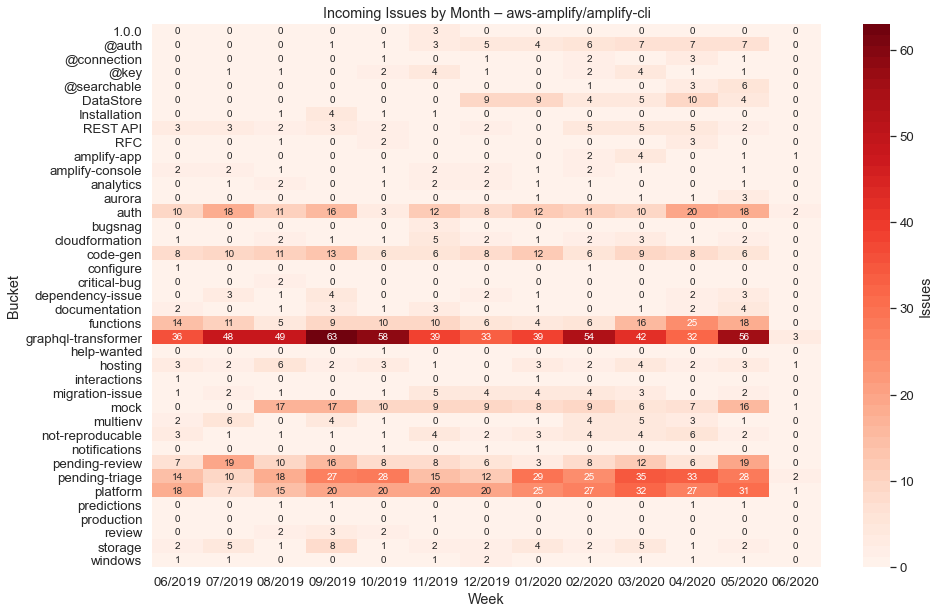

In [ ]:
# Incoming Issues by Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():    
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').count().transpose()
    
    if (len(df)):
        plt.subplots(figsize=(15, 10))

        dates = df.columns.strftime('%m/%Y').unique()
        ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='.0f', annot=True,
                         cbar_kws={'label': 'Issues'})

        ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Month – {repo_name}')
        plt.yticks(rotation=0)
        plt.show()

In [ ]:
# Open Issues Activity by Open Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 10))
    
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='score')
    df = df.resample('M', label='right').sum().transpose()

    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette('Reds', 50), annot=True, fmt='.0f',
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Issue Activity by Open Month – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

In [ ]:
from datetime import datetime
from IPython.display import display, HTML

total = (datetime.now() - start).seconds
minutes, seconds = divmod(total, 60)

if minutes:
    display(HTML(f'<em>Report generation took {minutes}min, {seconds}sec'))
else:
    display(HTML(f'<em>Report generation took {seconds}sec'))